In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

In [5]:
# Load and preprocess images from a directory
def load_and_preprocess(path, target_size=(220, 220)):
    images = []
    for filename in os.listdir(path):
        if filename.endswith((".jpg", ".jpeg", ".png")):
            image_path = os.path.join(path, filename)
            img = load_img(image_path, target_size=target_size)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
            images.append(img_array)
    return np.array(images)

# Example: Load images from a directory
path = r'/Users/harshdhiman/Documents/Research /Codes/Turbine Blade Damage Detection/training_imgs/Edge_Area'
image_data = load_and_preprocess(path)


In [6]:
image_data.shape

(241, 220, 220, 3)

In [28]:
# Define the autoencoder model
def build_autoencoder(input_shape):
    model = models.Sequential()

    # Encoder
    model.add(layers.InputLayer(input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), activation='relu',padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2), padding='same'))

    # Decoder
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.UpSampling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Conv2D(3,(3,3),activation='relu'))
    model.add(layers.UpSampling2D((2, 2)))
    #model.add(layers.UpSampling2D((2, 2))) # 224x224x32
    #model.add(layers.Conv2D(3, (3, 3), activation='relu')) # 222 x 222 x 3
    #model.add(layers.Conv2D(3, (3, 3), activation='sigmoid')) # 220 x 220 x 3
    return model

# Build the autoencoder
input_shape = (220, 220, 3)
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')  # Mean Squared Error loss for image reconstruction

In [29]:
autoencoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 220, 220, 32)      896       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 110, 110, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 55, 55, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 55, 55, 128)       73856     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 28, 28, 128)      

In [34]:
# Train the autoencoder (using the same data for input and target)
autoencoder.fit(image_data,image_data, epochs=100, batch_size=32, shuffle=True)

# Reconstruct images
reconstructed_images = autoencoder.predict(image_data)

Epoch 1/100
8/8 [==============================] - 9s 1s/step - loss: 0.0046
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.0045
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.0042
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.0042
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.0040
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 0.0039
Epoch 7/100
8/8 [==============================] - 10s 1s/step - loss: 0.0037
Epoch 8/100
8/8 [==============================] - 10s 1s/step - loss: 0.0037
Epoch 9/100
8/8 [==============================] - 10s 1s/step - loss: 0.0036
Epoch 10/100
8/8 [==============================] - 10s 1s/step - loss: 0.0035
Epoch 11/100
8/8 [==============================] - 11s 1s/step - loss: 0.0036
Epoch 12/100
8/8 [==============================] - 10s 1s/step - loss: 0.0035
Epoch 13/100
8/8 [==============================] - 11s 1s/step - l

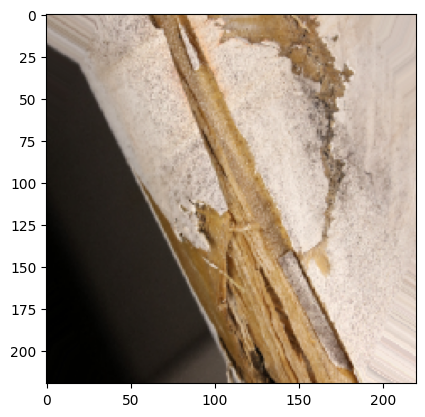

In [35]:
plt.imshow(image_data[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


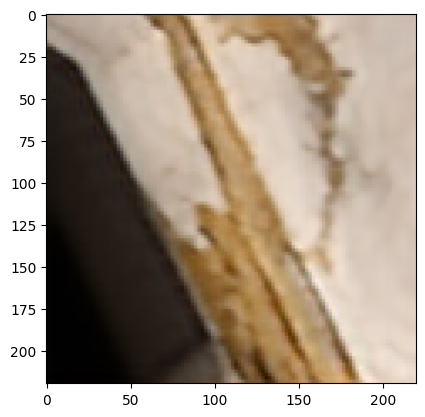

In [36]:
plt.imshow(reconstructed_images[10])